In [94]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [95]:
milk_data = pd.read_csv('../../monthly-milk-production.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
milk_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
milk    168 non-null int64
dtypes: int64(1)
memory usage: 2.6 KB


In [96]:
milk_data.head()

,milk
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


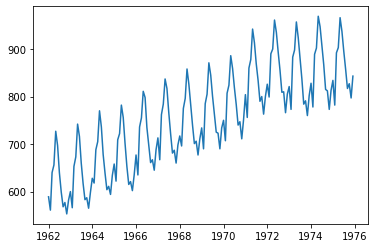

In [97]:
plt.plot(milk_data.index, milk_data.values)
plt.show()

Применим к ряду критерий Дики-Фуллера

In [98]:
sm.tsa.stattools.adfuller(milk_data.values.flatten())

(-1.3038115874221312,
 0.6274267086030308,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

Часто, когда вы имеете дело с величинами, представляющими собой сумму значений показателя за каждый день или за каждый рабочий день, имеет смысл перед началом прогнозирования поделить весь ряд на число дней в периоде. Например, если поделить ряд с объёмом производства молока на одну корову на число дней в месяце, полученная величина будет меняться более плавно, и для неё легче будет построить прогнозирующую модель.

Корректно определить число дней в месяце можно с помощью свойства days_in_month у индекса ряда или функции monthrange из пакета calendar. Используйте число дней в месяце для того, чтобы вычислить новый показатель — среднее дневное число полученного молока на одну корову. Постройте график этого ряда и убедитесь, что он стал более гладким.

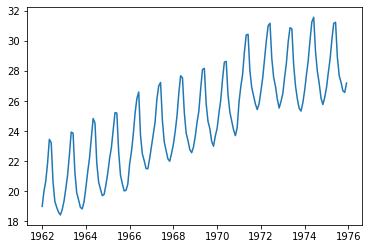

In [99]:
milk_data['daily'] = milk_data.milk.values.flatten() / milk_data.index.days_in_month
plt.plot(milk_data.index, milk_data.daily)

In [100]:
milk_data.daily.values.sum()

4166.326661899466

Для ряда со средним дневным количеством молока на корову из предыдущего вопроса давайте с помощью критерия Дики-Фуллера подберём порядок дифференцирования, при котором ряд становится стационарным.

При дифференцировании длина ряда сокращается, поэтому в части строк в новой колонке значения будут не определены (NaN). Подавая полученные столбцы на вход критерию Дики-Фуллера, отрезайте неопределённые значения, иначе вы получите неопределённый достигаемый уровень значимости.

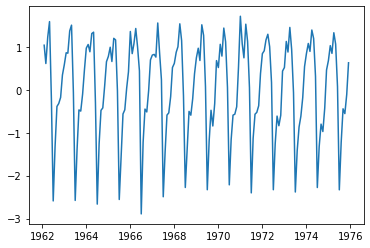

In [101]:
milk_data.daily_diff1 = milk_data.daily - milk_data.daily.shift(1) # дифференцирование
plt.plot(milk_data.index, milk_data.daily_diff1)
plt.show()

In [102]:
sm.tsa.stattools.adfuller(milk_data.daily_diff1.dropna())

(-2.759469476228914,
 0.06430054654174644,
 11,
 155,
 {'1%': -3.4732590518613002,
  '5%': -2.880374082105334,
  '10%': -2.5768120811654525},
 -1.153997338105512)

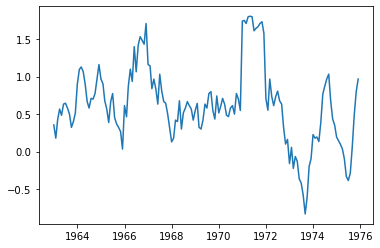

In [103]:
milk_data.season_diff = milk_data.daily - milk_data.daily.shift(12) # сезонное дифференцирование
plt.plot(milk_data.index, milk_data.season_diff)
plt.show()

In [104]:
sm.tsa.stattools.adfuller(milk_data.season_diff.dropna())

(-2.1594860932888085,
 0.22127672658830344,
 12,
 143,
 {'1%': -3.4769274060112707,
  '5%': -2.8819726324025625,
  '10%': -2.577665408088415},
 -25.225679141303317)

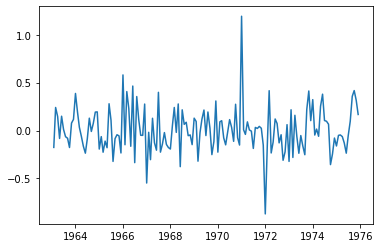

In [105]:
milk_data.season_diff_2 = milk_data.season_diff - milk_data.season_diff.shift(1)
plt.plot(milk_data.index, milk_data.season_diff_2)
plt.show()

In [106]:
sm.tsa.stattools.adfuller(milk_data.season_diff_2.dropna())

(-5.481326334796926,
 2.2808455518037347e-06,
 11,
 143,
 {'1%': -3.4769274060112707,
  '5%': -2.8819726324025625,
  '10%': -2.577665408088415},
 -20.90513750989237)

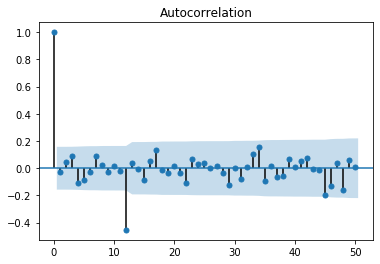

In [107]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(milk_data.season_diff_2.dropna().values.squeeze(), lags=50);

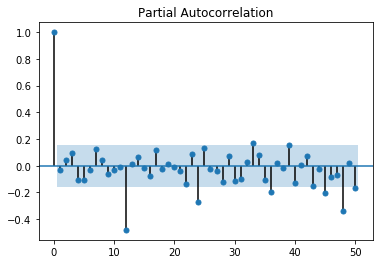

In [108]:
sm.graphics.tsa.plot_pacf(milk_data.season_diff_2.dropna().values.squeeze(), lags=50);

# Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [109]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y, lmbda):
    """Обратное преобразование Бокса-Кокса"""
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


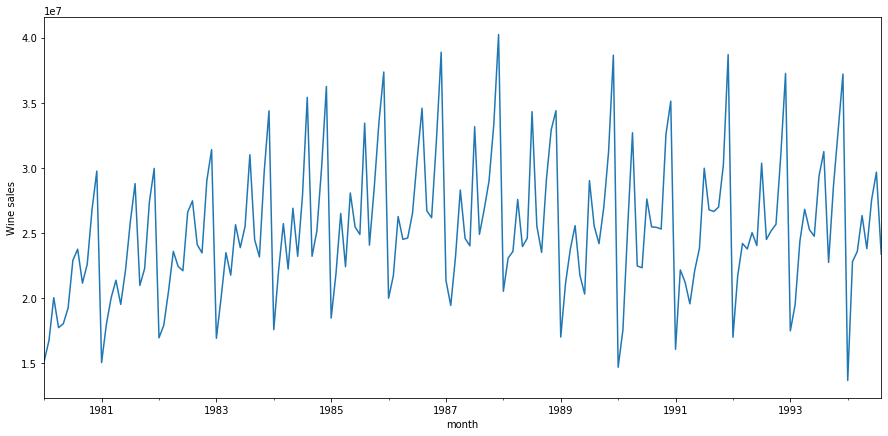

In [110]:
wine = pd.read_csv('../../monthly-australian-wine-sales.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
wine.sales = wine.sales * 1000
plt.figure(figsize(15,7))
wine.sales.plot()
plt.ylabel('Wine sales')
pylab.show();

У ряда достаточно сильно выраженная годовая сезонность, кроме того кажется, что здесь есть какой-то тренд, не линейный, но тем не менее, возможно, этот тренд можно как-то описать. Кроме того, у этого ряда, кажется, нестационарная дисперсия. Размах сезонных колебаний в начале ряда немного меньше, чем ближе к концу ряда. Прежде чем начинать этот ряд моделировать, давайте ещё немного его предварительно поанализируем. 

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.051161


<Figure size 1080x720 with 0 Axes>

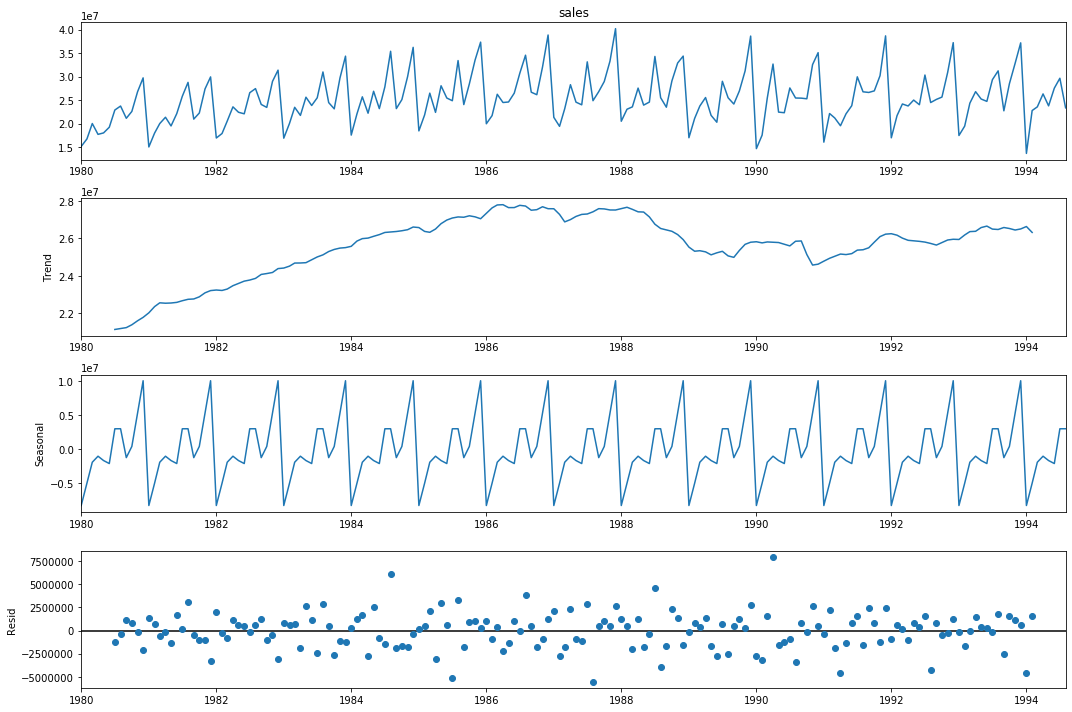

In [111]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales)[1])
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wine.sales).plot();

STL-декомпозиция — это некоторый набор эвристик, который позволяет вам визуально посмотреть, из каких примерно компонент состоит ваш ряд.   
На верхнем из четырёх графиков — исходный ряд. На нижних трёх соответственно тренд, сезонность и остатки.  
Сезонный профиль достаточно хорошо выражен. Тренд имеет достаточно сложную структуру. Сначала он повышается, затем доходит до некоторого пика, немного понижается и медленно возвращается на исходный уровень. Это ещё раз нам подтверждает, что ряд трудно считать стационарным. 

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.236675
Критерий Дики-Фуллера: p=0.029565


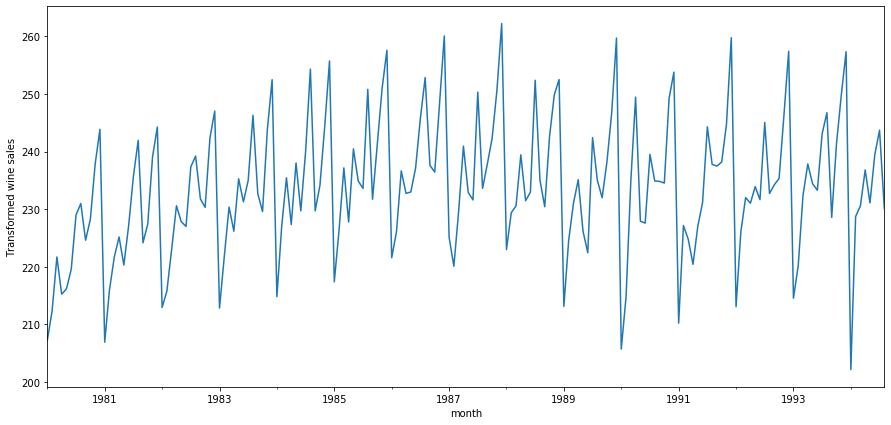

In [112]:
wine['sales_box'], lmbda = stats.boxcox(wine.sales)
plt.figure(figsize(15,7))
wine.sales_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box)[1]);

Критерий Дики-Фуллера на этом ряде даёт достигаемый уровень значимости примерно 0,03. То есть нулевая гипотеза нестационарности отвергается, и этот ряд критерий Дики-Фуллера считает стационарным. Тем не менее, мы очень хорошо видим, что стационарным этот ряд считать нельзя, потому что, во-первых, в нём очень сильно выражена сезонность, во-вторых, в нём есть вот тот самый тренд, который мы наблюдали на STL-декомпозиции. Критерий Дики-Фуллера — это всего лишь инструмент, и не очень совершенный. Поэтому, если вы видите, что ваш ряд явно не стационарен, не нужно доверять тому, что говорит вам критерий Дики-Фуллера.

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.128317


<Figure size 1080x720 with 0 Axes>

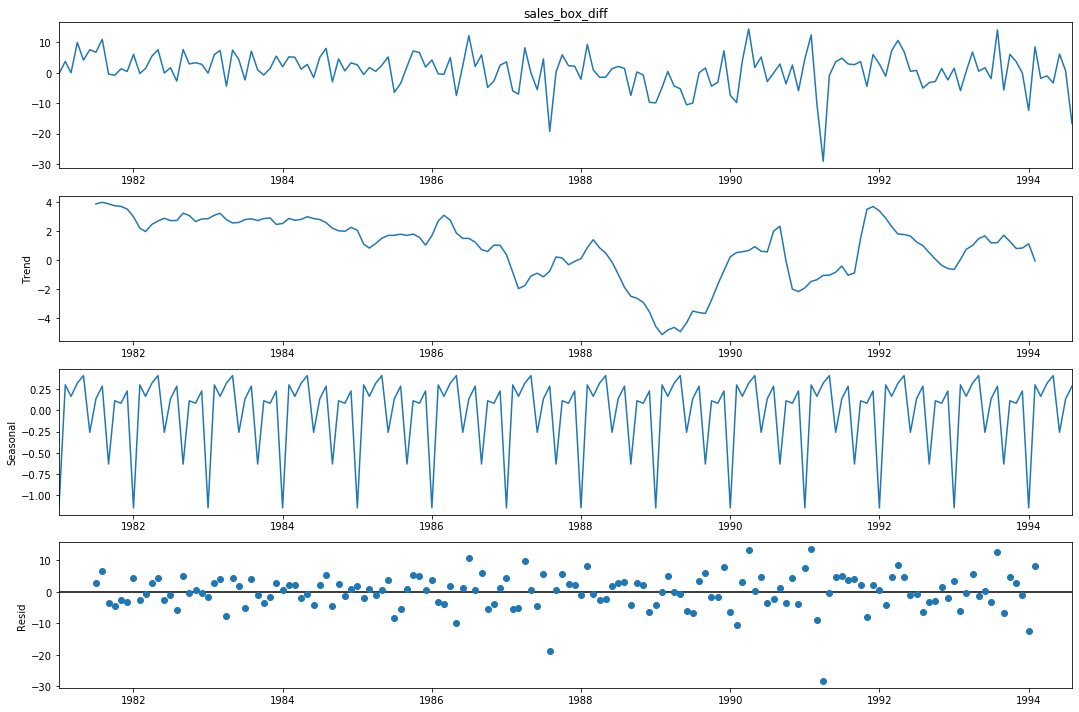

In [113]:
wine['sales_box_diff'] = wine.sales_box - wine.sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wine.sales_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box_diff[12:])[1]);

Изменился тренд. Он практически константный на первом участке ряда, но вот в месте, где происходил в исходном ряде перегиб тренда, мы видим существенный провал. То есть не удивительно, что этот ряд остался нестационарным. 

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000002


<Figure size 1080x720 with 0 Axes>

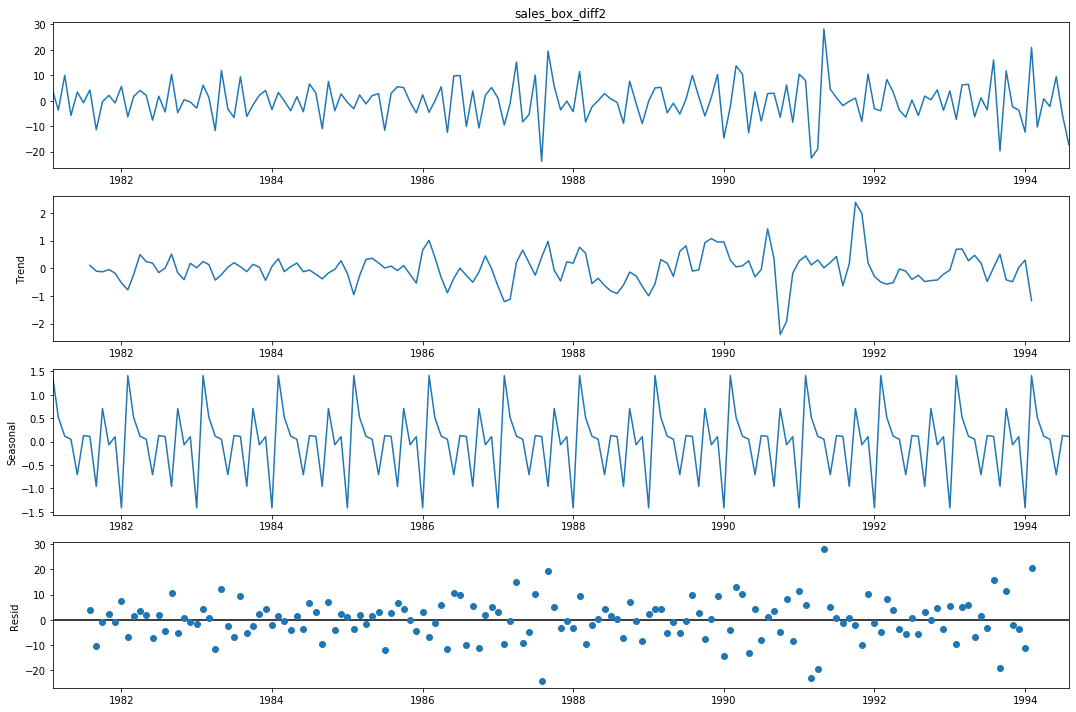

In [114]:
wine['sales_box_diff2'] = wine.sales_box_diff - wine.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wine.sales_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box_diff2[13:])[1]);

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

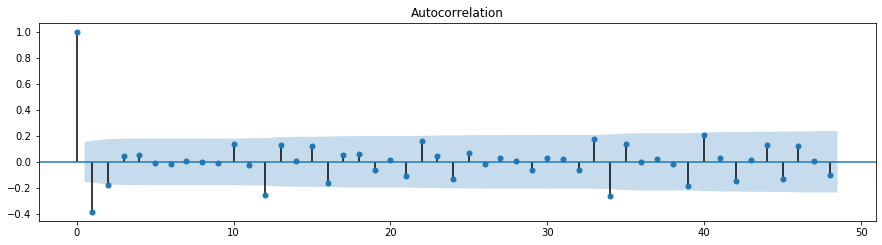

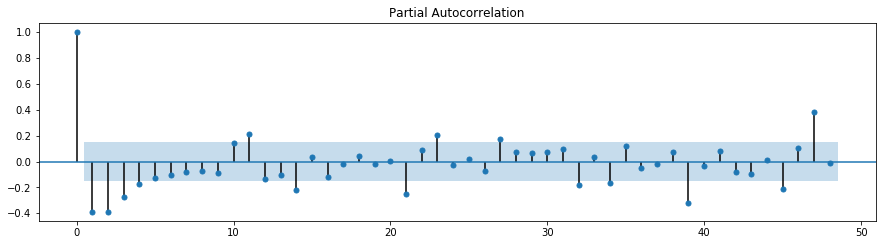

In [115]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wine.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wine.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show();

Теперь с этим начальным приближением будем делать перебор. Переберём все значения параметров p, P и q, Q от нуля до вот этих приближений, которые мы подобрали по графикам автокорреляционных функций. Всего таких моделей будет 60.

Начальные приближения: Q=1, q=2, P=1, p=4

In [116]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [117]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

Настроим все их и посчитаем для каждой значение информационного критерия Акаике, выберем ту модель, у которой это значение будет минимальным. 

In [70]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wine.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 25.3 s


In [81]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
21  (1, 2, 0, 1)  1006.024314
29  (2, 1, 0, 1)  1007.801388
31  (2, 1, 1, 1)  1008.786373
45  (3, 2, 0, 1)  1009.167726
33  (2, 2, 0, 1)  1009.284102


Лучшая модель:

In [82]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            sales_box   No. Observations:                  176
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -498.012
Date:                              Sun, 04 Apr 2021   AIC                           1006.024
Time:                                      17:42:19   BIC                           1021.493
Sample:                                  01-01-1980   HQIC                          1012.304
                                       - 08-01-1994                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9103      0.053     17.036      0.000       0.806       1.015
ma.L1         -1.93

Её остатки:

c:\users\lazpr\pycharmprojects\basicofstatistic\env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.384983
Критерий Дики-Фуллера: p=0.000000


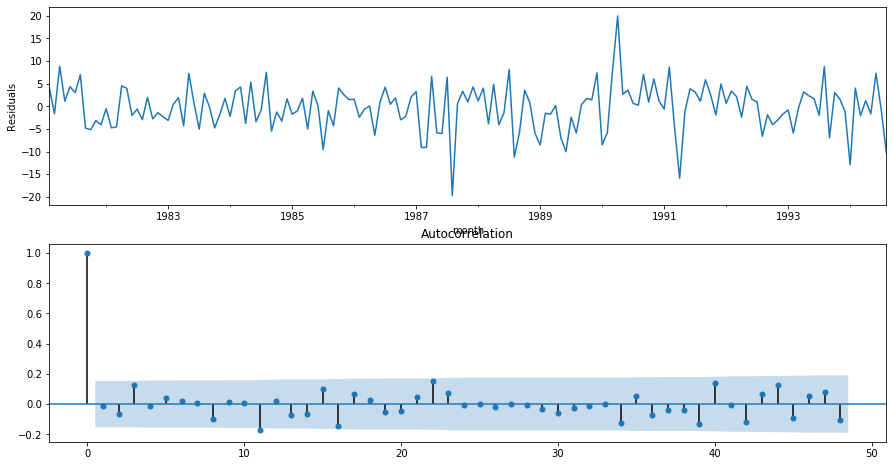

In [83]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1]);

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

<Figure size 1080x504 with 0 Axes>

Text(0, 0.5, 'Wine sales')

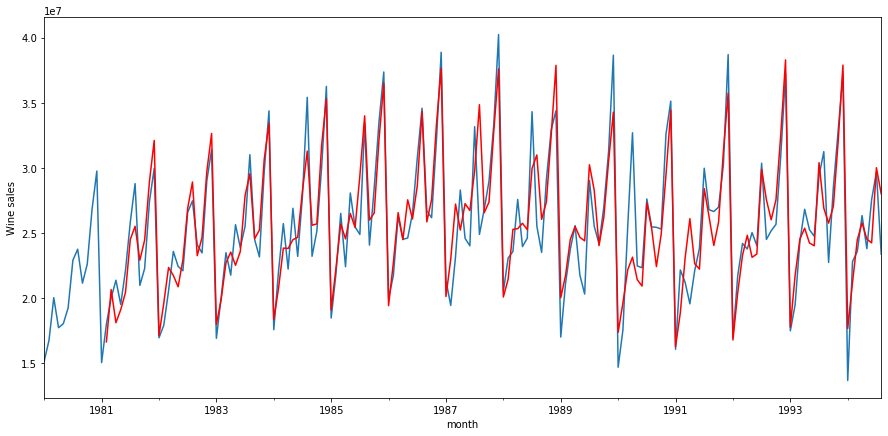

In [91]:
wine['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wine.sales.plot()
wine.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### Прогноз

<Figure size 1080x504 with 0 Axes>

Text(0, 0.5, 'Wine sales')

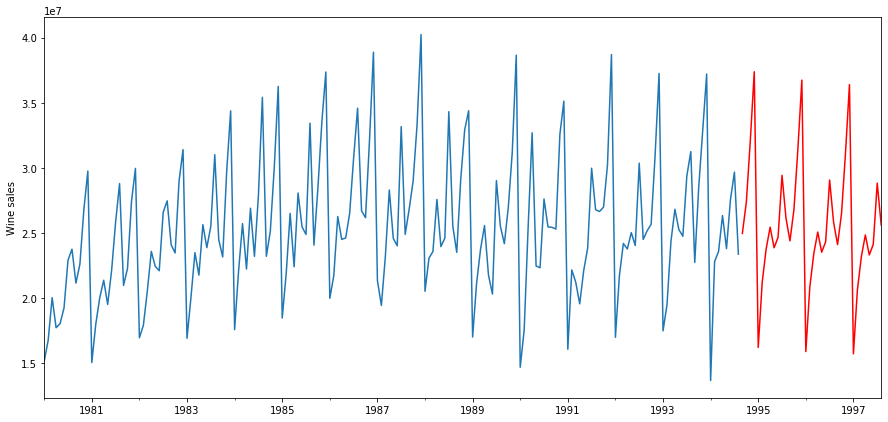

In [90]:
wine2 = wine[['sales']]
date_list = [datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wine2.columns)
wine2 = pd.concat([wine2, future])
wine2['forecast'] = invboxcox(best_model.predict(start=176, end=211), lmbda)

plt.figure(figsize(15,7))
wine2.sales.plot()
wine2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()